In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.enable_eager_execution()
tf.random.set_random_seed(42)

!pip install yfinance
!pip install quandl

  Created wheel for yfinance: filename=yfinance-0.1.50-py2.py3-none-any.whl size=21556 sha256=2cc9962448d45c021c4e04eb3ca5be0d0a0b983cde4f0d3ff79c60e509b89ba4
  Stored in directory: /root/.cache/pip/wheels/19/2a/e6/b4d4cc977576e18220a36866acf2f2cf7241f16af5f8795b17
Successfully built yfinance
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 2.3MB 14.2MB/s 
  Created wheel for inflection: filename=inflection-0.3.1-cp36-none-any.whl size=6076 sha256=ee891c93323f6e9e7228272367e4b0d63d8b3370e5aa7154c4cd750f7e505041
  Stored in directory: /root/.cache/pip/wheels/9f/5a/d3/6fc3bf6516d2a3eb7e18f9f28b472110b59325f3f258fe9211
Successfully built inflection
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: more-itertools 7.2.0
    Uninstalling more-itertools-7.2.0:
      Successfully uninstalled more-itertools-7

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Importing the libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, BatchNormalization, LeakyReLU
from keras.optimizers import SGD, Adam
from keras import regularizers
import math
import os
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

import yfinance as yf  
import quandl

from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


### Helper functions

In [0]:
def correlation(data):
  C = data.corr()
  # Generate a mask for the upper triangle
  mask = np.zeros_like(C, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True
  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))
  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap = True)
  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(C, mask = mask, annot = True, cmap = cmap, vmax = .3, center = 0, square = True, linewidths = .5, cbar_kws = {"shrink": .5})
  # fix for mpl bug that cuts off top/bottom of seaborn viz
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() 

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 2]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
        label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

def lr_fit(data, target):
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)
  lr = LinearRegression()
  sc = StandardScaler()
  lr.fit(sc.fit_transform(X_train), y_train)
  score = lr.score(sc.transform(X_test), y_test)
  return lr.coef_, score

In [0]:
path = './drive/My Drive/Stock_price/data'

### Data Gathering

In [6]:
# First, we get the data
 
dow = yf.download('^DJI','1990-01-01')
sp500 = yf.download('^GSPC','1990-01-01')
rus2000 = yf.download('^RUT','1990-01-01')
nasdaq = yf.download('^IXIC','1990-01-01')
vix = yf.download('^VIX','1990-01-01')#
gld = quandl.get("LBMA/GOLD", start_date="1990-01-01", authtoken="apP_kWe6TQYRTmw7pTMg")#
tlt = yf.download('TLT','1990-01-01')#
tnx = yf.download('^TNX','1990-01-01')#
oil = quandl.get("ODA/POILBRE_USD", start_date="1990-01-01", authtoken="apP_kWe6TQYRTmw7pTMg")#

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [0]:
misery = quandl.get("USMISERY/INDEX", start_date="1990-01-01", authtoken="apP_kWe6TQYRTmw7pTMg")
misery = misery.drop(['Misery Index'], axis = 1)
cpi = quandl.get("RATEINF/CPI_USA", start_date="1990-01-01", authtoken="apP_kWe6TQYRTmw7pTMg") #Consumer Price Index
man = quandl.get("FED/IP_B00004_S", start_date="1990-01-01", authtoken="apP_kWe6TQYRTmw7pTMg") #Manufacturing
debt = quandl.get("FRED/GFDEBTN", start_date="1990-01-01", authtoken="apP_kWe6TQYRTmw7pTMg")
oil_c = quandl.get("BP/OIL_CONSUM_D_USA", start_date="1990-01-01", authtoken="apP_kWe6TQYRTmw7pTMg") #Oil consumptiom

macro = pd.concat([misery, cpi, man, debt, oil_c], axis = 1)
macro.columns = ['CPI', 'Manufacturing', 'Debt', 'Oil consumption', 'Unemployment rate', 'Inflation rate']

### Data cleanup

In [8]:
macro.head(20)

,CPI,Manufacturing,Debt,Oil consumption,Unemployment rate,Inflation rate
Date,,,,,,
1990-01-01,NaN,NaN,NaN,NaN,3051958.0,NaN
1990-01-31,5.4,5.20,127.4,62.5981,NaN,NaN
1990-02-28,5.3,5.26,128.0,63.5189,NaN,NaN
1990-03-31,5.2,5.23,128.7,63.8311,NaN,NaN
1990-04-01,NaN,NaN,NaN,NaN,3143754.0,NaN
1990-04-30,5.4,4.71,128.9,63.6817,NaN,NaN
1990-05-31,5.4,4.36,129.2,63.7714,NaN,NaN
1990-06-30,5.2,4.67,129.9,63.9590,NaN,NaN
1990-07-01,NaN,NaN,NaN,NaN,3233313.0,NaN


In [9]:
macro.isnull().any()

CPI                  True
Manufacturing        True
Debt                 True
Oil consumption      True
Unemployment rate    True
Inflation rate       True
dtype: bool

In [10]:
macro = macro.fillna(method='bfill')
macro.isnull().any()

CPI                  False
Manufacturing        False
Debt                 False
Oil consumption      False
Unemployment rate     True
Inflation rate        True
dtype: bool

In [11]:
macro.head(20)

,CPI,Manufacturing,Debt,Oil consumption,Unemployment rate,Inflation rate
Date,,,,,,
1990-01-01,5.4,5.20,127.4,62.5981,3051958.0,16988.255518
1990-01-31,5.4,5.20,127.4,62.5981,3143754.0,16988.255518
1990-02-28,5.3,5.26,128.0,63.5189,3143754.0,16988.255518
1990-03-31,5.2,5.23,128.7,63.8311,3143754.0,16988.255518
1990-04-01,5.4,4.71,128.9,63.6817,3143754.0,16988.255518
1990-04-30,5.4,4.71,128.9,63.6817,3233313.0,16988.255518
1990-05-31,5.4,4.36,129.2,63.7714,3233313.0,16988.255518
1990-06-30,5.2,4.67,129.9,63.9590,3233313.0,16988.255518
1990-07-01,5.5,4.82,130.4,63.8667,3233313.0,16988.255518


In [12]:
macro.tail(20)

,CPI,Manufacturing,Debt,Oil consumption,Unemployment rate,Inflation rate
Date,,,,,,
2018-07-01,3.9,2.95,252.006,105.2254,21516058.0,20455.668043
2018-07-31,3.9,2.95,252.006,105.2254,21974096.0,20455.668043
2018-08-31,3.9,2.70,252.146,105.6772,21974096.0,20455.668043
2018-09-30,3.7,2.28,252.439,105.6946,21974096.0,20455.668043
2018-10-01,3.7,2.52,252.885,105.6096,21974096.0,20455.668043
2018-10-31,3.7,2.52,252.885,105.6096,22027880.0,20455.668043
2018-11-30,3.7,2.18,252.038,105.7933,22027880.0,20455.668043
2018-12-31,3.9,1.91,251.233,106.4076,22027880.0,20455.668043
2019-01-01,4.0,1.55,251.712,105.8163,22027880.0,NaN


In [13]:
macro = macro.fillna(method='ffill')
macro.isnull().any()

CPI                  False
Manufacturing        False
Debt                 False
Oil consumption      False
Unemployment rate    False
Inflation rate       False
dtype: bool

In [14]:
macro.head(20)

,CPI,Manufacturing,Debt,Oil consumption,Unemployment rate,Inflation rate
Date,,,,,,
1990-01-01,5.4,5.20,127.4,62.5981,3051958.0,16988.255518
1990-01-31,5.4,5.20,127.4,62.5981,3143754.0,16988.255518
1990-02-28,5.3,5.26,128.0,63.5189,3143754.0,16988.255518
1990-03-31,5.2,5.23,128.7,63.8311,3143754.0,16988.255518
1990-04-01,5.4,4.71,128.9,63.6817,3143754.0,16988.255518
1990-04-30,5.4,4.71,128.9,63.6817,3233313.0,16988.255518
1990-05-31,5.4,4.36,129.2,63.7714,3233313.0,16988.255518
1990-06-30,5.2,4.67,129.9,63.9590,3233313.0,16988.255518
1990-07-01,5.5,4.82,130.4,63.8667,3233313.0,16988.255518


In [15]:
macro.tail(20)

,CPI,Manufacturing,Debt,Oil consumption,Unemployment rate,Inflation rate
Date,,,,,,
2018-07-01,3.9,2.95,252.006,105.2254,21516058.0,20455.668043
2018-07-31,3.9,2.95,252.006,105.2254,21974096.0,20455.668043
2018-08-31,3.9,2.70,252.146,105.6772,21974096.0,20455.668043
2018-09-30,3.7,2.28,252.439,105.6946,21974096.0,20455.668043
2018-10-01,3.7,2.52,252.885,105.6096,21974096.0,20455.668043
2018-10-31,3.7,2.52,252.885,105.6096,22027880.0,20455.668043
2018-11-30,3.7,2.18,252.038,105.7933,22027880.0,20455.668043
2018-12-31,3.9,1.91,251.233,106.4076,22027880.0,20455.668043
2019-01-01,4.0,1.55,251.712,105.8163,22027880.0,20455.668043


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc54b67ac18>,
      dtype=object)

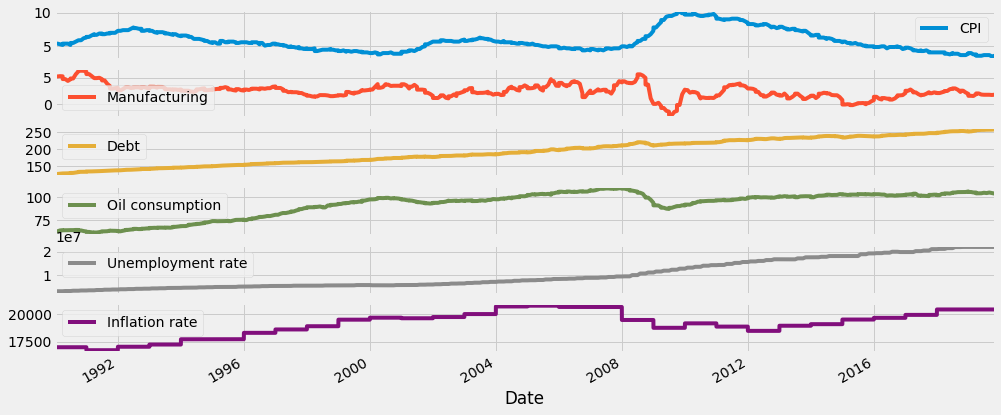

In [16]:
macro.plot(subplots=True, figsize=(15,7))

In [17]:
market = pd.concat([dow['Close'], sp500['Close'], rus2000['Close'], nasdaq['Close'], 
                    vix['Close'], gld['USD (AM)'], tlt['Close'], tnx['Close'], oil], axis =1, join_axes=[gld.index])
market.columns = ['dow', 'sp500', 'rus2000', 'nasdaq', 'vix', 'gld', 'tlt', 'tnx', 'oil']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  


In [18]:
market.drop_duplicates(subset=None, keep='first', inplace=False)

,dow,sp500,rus2000,nasdaq,vix,gld,tlt,tnx,oil
Date,,,,,,,,,
1990-01-02,2810.149902,359.690002,169.949997,459.299988,17.240000,401.65,NaN,7.940,NaN
1990-01-03,2809.729980,358.760010,170.789993,460.899994,18.190001,396.30,NaN,7.990,NaN
1990-01-04,2796.080078,355.670013,170.089996,459.399994,19.219999,394.95,NaN,7.980,NaN
1990-01-05,2773.250000,352.200012,169.649994,458.200012,20.110001,401.20,NaN,7.990,NaN
1990-01-08,2794.370117,353.790009,169.550003,458.700012,20.260000,403.75,NaN,8.020,NaN
...,...,...,...,...,...,...,...,...,...
2019-11-11,27691.490234,3087.010010,1594.770020,8464.280273,12.690000,1465.50,135.000000,1.943,NaN
2019-11-12,27691.490234,3091.840088,1595.119995,8486.089844,12.680000,1455.00,135.619995,1.909,NaN
2019-11-13,27783.589844,3094.040039,1589.180054,8482.099609,13.000000,1463.45,136.500000,1.870,NaN


In [19]:
market.shape

(7553, 9)

In [20]:
market.head(20)

,dow,sp500,rus2000,nasdaq,vix,gld,tlt,tnx,oil
Date,,,,,,,,,
1990-01-02,2810.149902,359.690002,169.949997,459.299988,17.240000,401.65,NaN,7.94,NaN
1990-01-03,2809.729980,358.760010,170.789993,460.899994,18.190001,396.30,NaN,7.99,NaN
1990-01-04,2796.080078,355.670013,170.089996,459.399994,19.219999,394.95,NaN,7.98,NaN
1990-01-05,2773.250000,352.200012,169.649994,458.200012,20.110001,401.20,NaN,7.99,NaN
1990-01-08,2794.370117,353.790009,169.550003,458.700012,20.260000,403.75,NaN,8.02,NaN
1990-01-09,2766.000000,349.619995,169.300003,456.799988,22.200001,402.70,NaN,8.02,NaN
1990-01-10,2750.639893,347.309998,167.940002,450.700012,22.440001,405.85,NaN,8.03,NaN
1990-01-11,2760.669922,348.529999,168.009995,448.899994,20.049999,413.55,NaN,8.04,NaN
1990-01-12,2689.209961,339.929993,164.369995,439.700012,24.639999,413.90,NaN,8.10,NaN


In [21]:
market.isnull().any()

dow         True
sp500       True
rus2000     True
nasdaq      True
vix         True
gld        False
tlt         True
tnx         True
oil         True
dtype: bool

In [22]:
market = market.fillna(method='bfill')
market.isnull().any()

dow        False
sp500      False
rus2000    False
nasdaq     False
vix        False
gld        False
tlt        False
tnx        False
oil         True
dtype: bool

In [23]:
market.head(20)

,dow,sp500,rus2000,nasdaq,vix,gld,tlt,tnx,oil
Date,,,,,,,,,
1990-01-02,2810.149902,359.690002,169.949997,459.299988,17.240000,401.65,81.519997,7.94,21.25
1990-01-03,2809.729980,358.760010,170.789993,460.899994,18.190001,396.30,81.519997,7.99,21.25
1990-01-04,2796.080078,355.670013,170.089996,459.399994,19.219999,394.95,81.519997,7.98,21.25
1990-01-05,2773.250000,352.200012,169.649994,458.200012,20.110001,401.20,81.519997,7.99,21.25
1990-01-08,2794.370117,353.790009,169.550003,458.700012,20.260000,403.75,81.519997,8.02,21.25
1990-01-09,2766.000000,349.619995,169.300003,456.799988,22.200001,402.70,81.519997,8.02,21.25
1990-01-10,2750.639893,347.309998,167.940002,450.700012,22.440001,405.85,81.519997,8.03,21.25
1990-01-11,2760.669922,348.529999,168.009995,448.899994,20.049999,413.55,81.519997,8.04,21.25
1990-01-12,2689.209961,339.929993,164.369995,439.700012,24.639999,413.90,81.519997,8.10,21.25


In [24]:
market.tail(20)

,dow,sp500,rus2000,nasdaq,vix,gld,tlt,tnx,oil
Date,,,,,,,,,
2019-10-21,26827.640625,3006.719971,1552.410034,8162.990234,14.00,1490.85,138.529999,1.792,59.37
2019-10-22,26788.099609,2995.989990,1550.869995,8104.299805,14.46,1487.45,139.339996,1.768,59.37
2019-10-23,26833.949219,3004.520020,1552.859985,8119.790039,14.01,1494.25,139.479996,1.759,59.37
2019-10-24,26805.529297,3010.290039,1548.489990,8185.799805,13.71,1488.85,139.199997,1.766,59.37
2019-10-25,26958.060547,3022.550049,1558.709961,8243.120117,12.65,1504.65,138.520004,1.801,59.37
2019-10-28,27090.720703,3039.419922,1571.930054,8325.990234,13.11,1505.05,137.259995,1.853,59.37
2019-10-29,27071.460938,3036.889893,1577.069946,8276.849609,13.20,1492.75,137.350006,1.835,59.37
2019-10-30,27186.689453,3046.770020,1572.849976,8303.980469,12.33,1490.15,139.360001,1.798,59.37
2019-10-31,27046.230469,3037.560059,1562.449951,8292.360352,13.22,1506.40,141.240005,1.691,59.37


In [25]:
market = market.fillna(method='ffill')
market.isnull().any()

dow        False
sp500      False
rus2000    False
nasdaq     False
vix        False
gld        False
tlt        False
tnx        False
oil        False
dtype: bool

In [26]:
market.head(20)

,dow,sp500,rus2000,nasdaq,vix,gld,tlt,tnx,oil
Date,,,,,,,,,
1990-01-02,2810.149902,359.690002,169.949997,459.299988,17.240000,401.65,81.519997,7.94,21.25
1990-01-03,2809.729980,358.760010,170.789993,460.899994,18.190001,396.30,81.519997,7.99,21.25
1990-01-04,2796.080078,355.670013,170.089996,459.399994,19.219999,394.95,81.519997,7.98,21.25
1990-01-05,2773.250000,352.200012,169.649994,458.200012,20.110001,401.20,81.519997,7.99,21.25
1990-01-08,2794.370117,353.790009,169.550003,458.700012,20.260000,403.75,81.519997,8.02,21.25
1990-01-09,2766.000000,349.619995,169.300003,456.799988,22.200001,402.70,81.519997,8.02,21.25
1990-01-10,2750.639893,347.309998,167.940002,450.700012,22.440001,405.85,81.519997,8.03,21.25
1990-01-11,2760.669922,348.529999,168.009995,448.899994,20.049999,413.55,81.519997,8.04,21.25
1990-01-12,2689.209961,339.929993,164.369995,439.700012,24.639999,413.90,81.519997,8.10,21.25


In [27]:
market.tail(20)

,dow,sp500,rus2000,nasdaq,vix,gld,tlt,tnx,oil
Date,,,,,,,,,
2019-10-21,26827.640625,3006.719971,1552.410034,8162.990234,14.00,1490.85,138.529999,1.792,59.37
2019-10-22,26788.099609,2995.989990,1550.869995,8104.299805,14.46,1487.45,139.339996,1.768,59.37
2019-10-23,26833.949219,3004.520020,1552.859985,8119.790039,14.01,1494.25,139.479996,1.759,59.37
2019-10-24,26805.529297,3010.290039,1548.489990,8185.799805,13.71,1488.85,139.199997,1.766,59.37
2019-10-25,26958.060547,3022.550049,1558.709961,8243.120117,12.65,1504.65,138.520004,1.801,59.37
2019-10-28,27090.720703,3039.419922,1571.930054,8325.990234,13.11,1505.05,137.259995,1.853,59.37
2019-10-29,27071.460938,3036.889893,1577.069946,8276.849609,13.20,1492.75,137.350006,1.835,59.37
2019-10-30,27186.689453,3046.770020,1572.849976,8303.980469,12.33,1490.15,139.360001,1.798,59.37
2019-10-31,27046.230469,3037.560059,1562.449951,8292.360352,13.22,1506.40,141.240005,1.691,59.37


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc54b6390f0>,
      dtype=object)

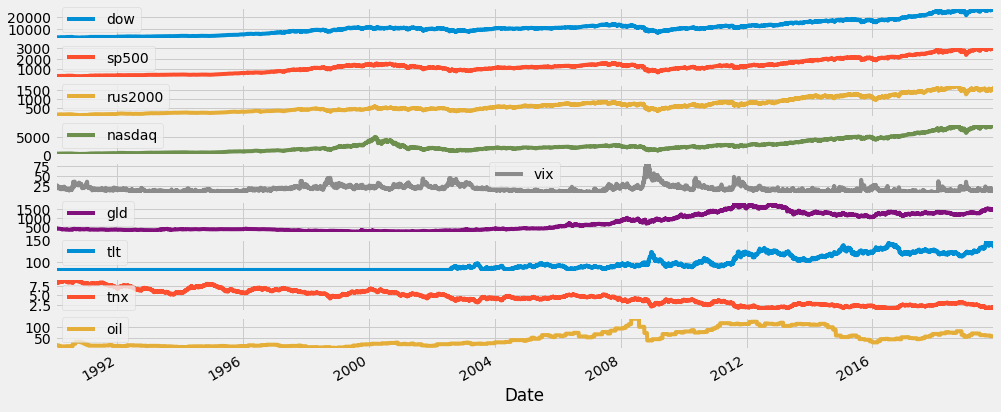

In [28]:
market.plot(subplots=True, figsize=(15,7))

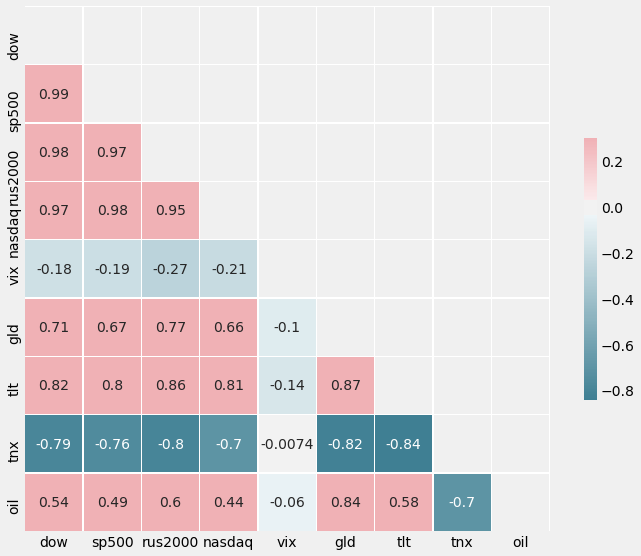

In [29]:
correlation(market)

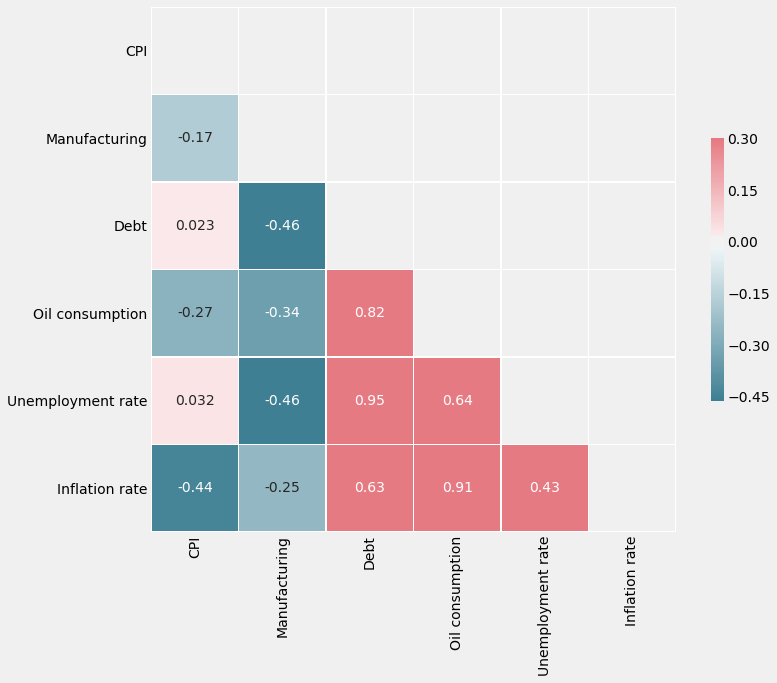

In [30]:
correlation(macro)

In [0]:
sum = pd.concat([market,macro], axis =1)
#market.columns = ['dow', 'sp500', 'rus2000', 'nasdaq', 'vix', 'gld', 'tlt', 'tnx', 'oil', 'aapl']

In [32]:
sum.head(20)

,dow,sp500,rus2000,nasdaq,vix,gld,tlt,tnx,oil,CPI,Manufacturing,Debt,Oil consumption,Unemployment rate,Inflation rate
Date,,,,,,,,,,,,,,,
1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4,5.2,127.4,62.5981,3051958.0,16988.255518
1990-01-02,2810.149902,359.690002,169.949997,459.299988,17.240000,401.65,81.519997,7.94,21.25,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,2809.729980,358.760010,170.789993,460.899994,18.190001,396.30,81.519997,7.99,21.25,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,2796.080078,355.670013,170.089996,459.399994,19.219999,394.95,81.519997,7.98,21.25,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,2773.250000,352.200012,169.649994,458.200012,20.110001,401.20,81.519997,7.99,21.25,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,2794.370117,353.790009,169.550003,458.700012,20.260000,403.75,81.519997,8.02,21.25,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-09,2766.000000,349.619995,169.300003,456.799988,22.200001,402.70,81.519997,8.02,21.25,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-10,2750.639893,347.309998,167.940002,450.700012,22.440001,405.85,81.519997,8.03,21.25,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-11,2760.669922,348.529999,168.009995,448.899994,20.049999,413.55,81.519997,8.04,21.25,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
sum.isnull().any()

dow                  True
sp500                True
rus2000              True
nasdaq               True
vix                  True
gld                  True
tlt                  True
tnx                  True
oil                  True
CPI                  True
Manufacturing        True
Debt                 True
Oil consumption      True
Unemployment rate    True
Inflation rate       True
dtype: bool

In [34]:
sum = sum.fillna(method='bfill')
sum.isnull().any()

dow                  False
sp500                False
rus2000              False
nasdaq               False
vix                  False
gld                  False
tlt                  False
tnx                  False
oil                  False
CPI                   True
Manufacturing         True
Debt                  True
Oil consumption       True
Unemployment rate     True
Inflation rate        True
dtype: bool

In [35]:
sum = sum.fillna(method='ffill')
sum.isnull().any()

dow                  False
sp500                False
rus2000              False
nasdaq               False
vix                  False
gld                  False
tlt                  False
tnx                  False
oil                  False
CPI                  False
Manufacturing        False
Debt                 False
Oil consumption      False
Unemployment rate    False
Inflation rate       False
dtype: bool

In [36]:
sum.head(20)

,dow,sp500,rus2000,nasdaq,vix,gld,tlt,tnx,oil,CPI,Manufacturing,Debt,Oil consumption,Unemployment rate,Inflation rate
Date,,,,,,,,,,,,,,,
1990-01-01,2810.149902,359.690002,169.949997,459.299988,17.240000,401.65,81.519997,7.94,21.25,5.4,5.2,127.4,62.5981,3051958.0,16988.255518
1990-01-02,2810.149902,359.690002,169.949997,459.299988,17.240000,401.65,81.519997,7.94,21.25,5.4,5.2,127.4,62.5981,3143754.0,16988.255518
1990-01-03,2809.729980,358.760010,170.789993,460.899994,18.190001,396.30,81.519997,7.99,21.25,5.4,5.2,127.4,62.5981,3143754.0,16988.255518
1990-01-04,2796.080078,355.670013,170.089996,459.399994,19.219999,394.95,81.519997,7.98,21.25,5.4,5.2,127.4,62.5981,3143754.0,16988.255518
1990-01-05,2773.250000,352.200012,169.649994,458.200012,20.110001,401.20,81.519997,7.99,21.25,5.4,5.2,127.4,62.5981,3143754.0,16988.255518
1990-01-08,2794.370117,353.790009,169.550003,458.700012,20.260000,403.75,81.519997,8.02,21.25,5.4,5.2,127.4,62.5981,3143754.0,16988.255518
1990-01-09,2766.000000,349.619995,169.300003,456.799988,22.200001,402.70,81.519997,8.02,21.25,5.4,5.2,127.4,62.5981,3143754.0,16988.255518
1990-01-10,2750.639893,347.309998,167.940002,450.700012,22.440001,405.85,81.519997,8.03,21.25,5.4,5.2,127.4,62.5981,3143754.0,16988.255518
1990-01-11,2760.669922,348.529999,168.009995,448.899994,20.049999,413.55,81.519997,8.04,21.25,5.4,5.2,127.4,62.5981,3143754.0,16988.255518


In [37]:
sum.shape

(7725, 15)

In [38]:
"""
# Random Forest

param_grid = {
    'criterion': ['mse', 'mae'],
    'max_depth': [10, 100, 150],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ["auto", "sqrt", "log2"],
    'n_estimators': [30, 40, 50],
}

rf = RandomForestRegressor(random_state = 42)
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5, verbose = 3)
CV_rf.fit(X_train, y_train)
CV_rf.best_params_
"""

'\n# Random Forest\n\nparam_grid = {\n    \'criterion\': [\'mse\', \'mae\'],\n    \'max_depth\': [10, 100, 150],\n    \'min_samples_leaf\': [1, 2, 5],\n    \'max_features\': ["auto", "sqrt", "log2"],\n    \'n_estimators\': [30, 40, 50],\n}\n\nrf = RandomForestRegressor(random_state = 42)\nCV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5, verbose = 3)\nCV_rf.fit(X_train, y_train)\nCV_rf.best_params_\n'

### Simple algos



In [39]:
# Let's see if we can use simple methods to predict prices days from now

targ = 'sp500'
df = pd.DataFrame(market[targ])
df.head()

,sp500
Date,
1990-01-02,359.690002
1990-01-03,358.760010
1990-01-04,355.670013
1990-01-05,352.200012
1990-01-08,353.790009


In [40]:
lookout = 10 # 30 days
#Create another column (the target or dependent variable) shifted 'n' units up
df['Prediction'] = df[[targ]].shift(-lookout)
#print the new data set
df.tail(lookout + 1)

,sp500,Prediction
Date,,
2019-11-01,3066.909912,3120.459961
2019-11-04,3078.270020,NaN
2019-11-05,3074.620117,NaN
2019-11-06,3076.780029,NaN
2019-11-07,3085.179932,NaN
2019-11-08,3093.080078,NaN
2019-11-11,3087.010010,NaN
2019-11-12,3091.840088,NaN
2019-11-13,3094.040039,NaN


In [41]:
X = np.array(df.drop(['Prediction'],1))

X = X[:-lookout]
y = np.array(df['Prediction'])

y = y[:-lookout]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape

((6034, 1), (6034,))

In [42]:
svr = SVR(kernel='linear', C=1, gamma=0.01, cache_size = 2000)
svr.fit(X_train, y_train)

SVR(C=1, cache_size=2000, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [43]:
svm_confidence = svr.score(X_test, y_test)
print("svm confidence: ", svm_confidence)

svm confidence:  0.996520181446219


In [44]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
lr_confidence = lr.score(X_test, y_test)
print("lr confidence: ", lr_confidence)

lr confidence:  0.9965831797115796


In [46]:
kn = KNeighborsRegressor()
kn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [47]:
kn_confidence = kn.score(X_test, y_test)
print("kn confidence: ", kn_confidence)

kn confidence:  0.9962514320222139


In [48]:
rf = RandomForestRegressor(n_estimators = 10, max_features = 'sqrt', min_samples_leaf = 1, criterion = 'mse' )
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [49]:
rf_confidence = rf.score(X_test, y_test)
print("rf confidence: ", rf_confidence)

rf confidence:  0.9950937634274671


In [50]:
# XGBoost
import xgboost as xgb

xgb = xgb.XGBRegressor()
xgb.fit(X_train, y_train)
print("xgb confidence: ", xgb.score(X_test, y_test))

[23:35:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgb confidence:  0.996606870238193


In [51]:
# Print linear regression model predictions for the next 30 days

X_forecast = np.array(df.drop(['Prediction'],1))[-lookout:]

lr_prediction = lr.predict(X_forecast)

svm_prediction = svr.predict(X_forecast)

rf_prediction = rf.predict(X_forecast)

xgb_prediction = xgb.predict(X_forecast)

kn_prediction = kn.predict(X_forecast)

print ("linear regression mean squared error:\n", mean_squared_error(lr_prediction, X_forecast))
print ("SVM mean squared error:\n", mean_squared_error(svm_prediction, X_forecast))
print ("Random forest mean squared error:\n", mean_squared_error(rf_prediction, X_forecast))
print ("XGBoost mean squared error:\n", mean_squared_error(xgb_prediction, X_forecast))
print ("K-nearest neighbors mean squared error:\n", mean_squared_error(kn_prediction, X_forecast))

linear regression mean squared error:
 76.38719168716364
SVM mean squared error:
 282.30277833977647
Random forest mean squared error:
 440.2306914353309
XGBoost mean squared error:
 158.67379833459853
K-nearest neighbors mean squared error:
 225.48135500907748


## Networks

In [0]:
TRAIN_SPLIT = int(.80*sum.shape[0])

In [53]:
uni_data = sum[targ]
uni_data.tail()

Date
2019-11-11    3087.010010
2019-11-12    3091.840088
2019-11-13    3094.040039
2019-11-14    3096.629883
2019-11-15    3120.459961
Name: sp500, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc53d1fc2b0>],
      dtype=object)

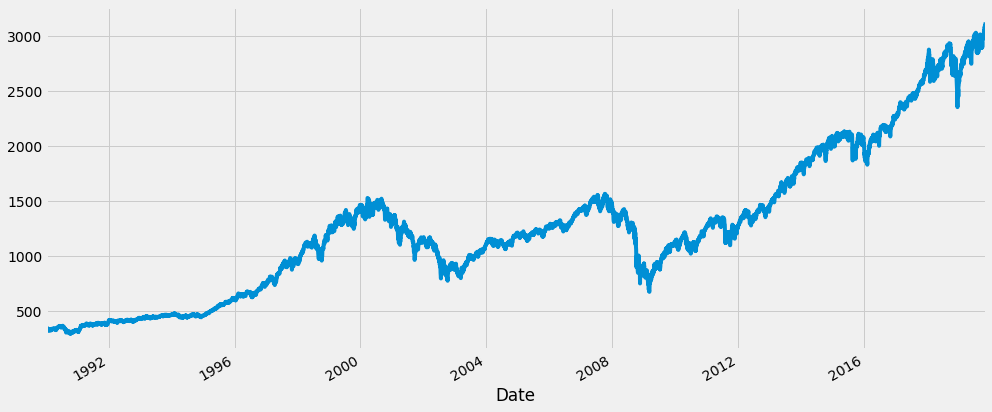

In [54]:
uni_data.plot(subplots=True, figsize=(15,7))

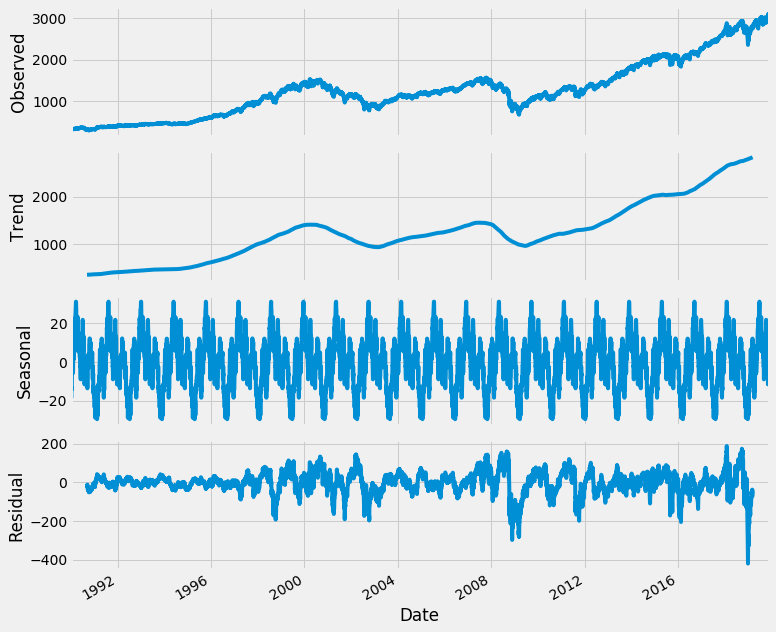

In [55]:
# Decomposition
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 11, 9
decomposed = sm.tsa.seasonal_decompose(sum[targ],freq=360) # annual frequency
figure = decomposed.plot()
plt.show()

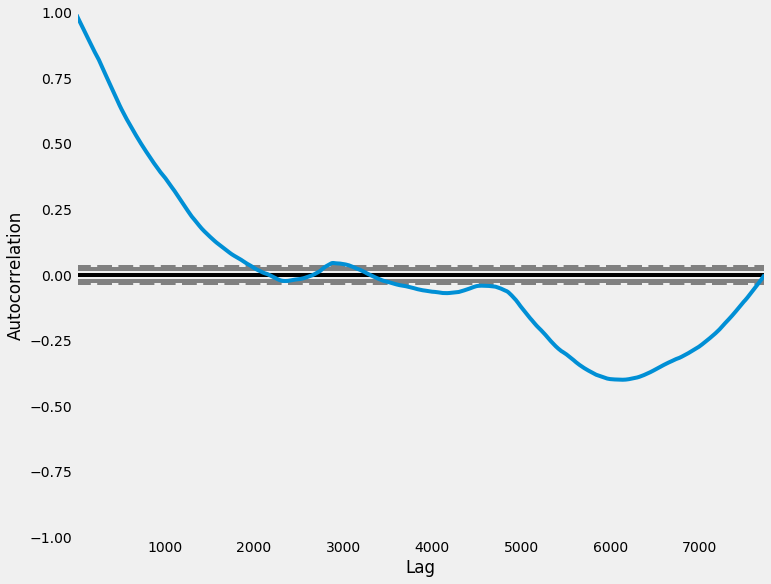

In [56]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(uni_data)

In [0]:
uni_data = uni_data.values

In [0]:
uni_data =  uni_data.reshape(-1, 1)

In [0]:
scm = MinMaxScaler(feature_range=(0, 1))
uni_data = scm.fit_transform(uni_data)

In [60]:
uni_data

array([[0.02273629],
       [0.02273629],
       [0.02240709],
       ...,
       [0.99064782],
       [0.99156457],
       [1.        ]])

In [0]:
"""
Let's now create the data for the univariate model. In this part, the model will be given the last 72 recorded observations,
and needs to learn to predict the price at the next time step.
"""
univariate_past_history = 60
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [62]:
print ('Single window of past history')
print (x_train_uni[1000])
print ('\n Target price to predict')
print (y_train_uni[1000])

Single window of past history
[[0.05956107]
 [0.05917877]
 [0.06015222]
 [0.05957169]
 [0.06063009]
 [0.05994691]
 [0.05952567]
 [0.05916461]
 [0.05793629]
 [0.05860885]
 [0.05907964]
 [0.05932744]
 [0.05932744]
 [0.05891682]
 [0.05887788]
 [0.05891328]
 [0.05934513]
 [0.05997523]
 [0.06052036]
 [0.06063718]
 [0.0604708 ]
 [0.05972389]
 [0.0596354 ]
 [0.06026195]
 [0.05932744]
 [0.05889558]
 [0.05942655]
 [0.06050266]
 [0.06031505]
 [0.06012035]
 [0.0608354 ]
 [0.06085664]
 [0.06198938]
 [0.06198938]
 [0.06130266]
 [0.06052744]
 [0.06068319]
 [0.06068319]
 [0.06091681]
 [0.0607646 ]
 [0.06174867]
 [0.06364956]
 [0.06324602]
 [0.06326019]
 [0.06265841]
 [0.06352213]
 [0.06295221]
 [0.0632885 ]
 [0.06330619]
 [0.06354691]
 [0.06345487]
 [0.06248142]
 [0.06210974]
 [0.06291682]
 [0.06427965]
 [0.06486372]
 [0.0658938 ]
 [0.06518938]
 [0.06603186]
 [0.06557522]]

 Target price to predict
[0.06171682]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

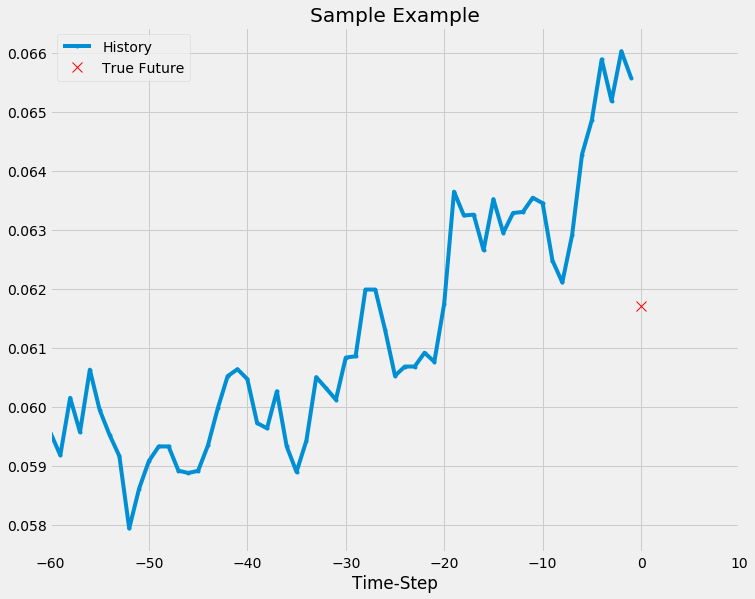

In [63]:
# Now that the data has been created, let's take a look at a single example. 
# The information given to the network is given in blue, and it must predict the value at the red cross.

show_plot([x_train_uni[1000], y_train_uni[1000]], 0, 'Sample Example')

(60, 1) (1,) ()


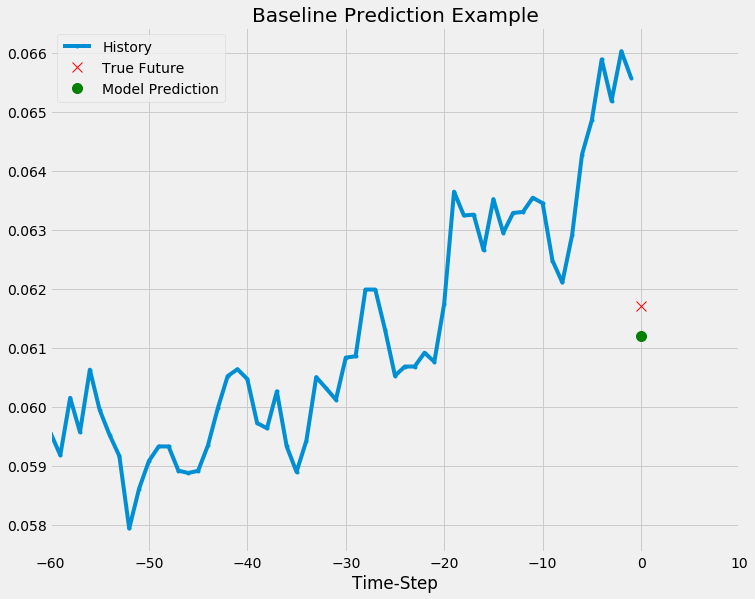

In [64]:
### Baseline
# Before proceeding to train a model, let's first set a simple baseline. 
# Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 30 observations.

def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[1000], y_train_uni[1000], baseline(x_train_uni[1000])], 0, 'Baseline Prediction Example')

print(x_train_uni[1000].shape, y_train_uni[1000].shape, baseline(x_train_uni[0]).shape)

In [65]:
x_train_uni.shape, y_train_uni.shape

((6120, 60, 1), (6120, 1))

### Univariate

In [66]:
### RNN

# tf.data to shuffle, batch, and cache the dataset.

BATCH_SIZE = 128
BUFFER_SIZE = 3000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

UV = tf.keras.models.Sequential([
    tf.keras.layers.GRU(32,return_sequences=False, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
UV.compile(optimizer='adam',loss='mae')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [67]:
UV.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3264      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 3,297
Trainable params: 3,297
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Load any existing weights
if os.path.exists(os.path.join(path, 'UV.h5')):
    UV.load_weights(os.path.join(path, 'UV.h5'))
    epochs = 0
else:
    epochs = 50

UV.fit(train_univariate, epochs = epochs, validation_data = val_univariate, steps_per_epoch = x_train_uni.shape[0]//BATCH_SIZE, validation_steps = x_val_uni.shape[0]//BATCH_SIZE)

Train for 47 steps, validate for 11 steps


In [0]:
if epochs!=0:
    UV.save_weights(os.path.join(path, 'UV.h5'))

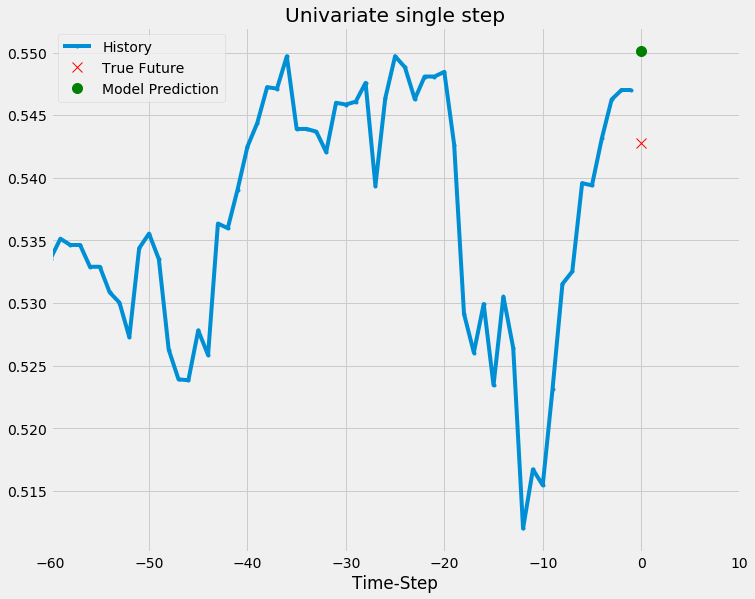

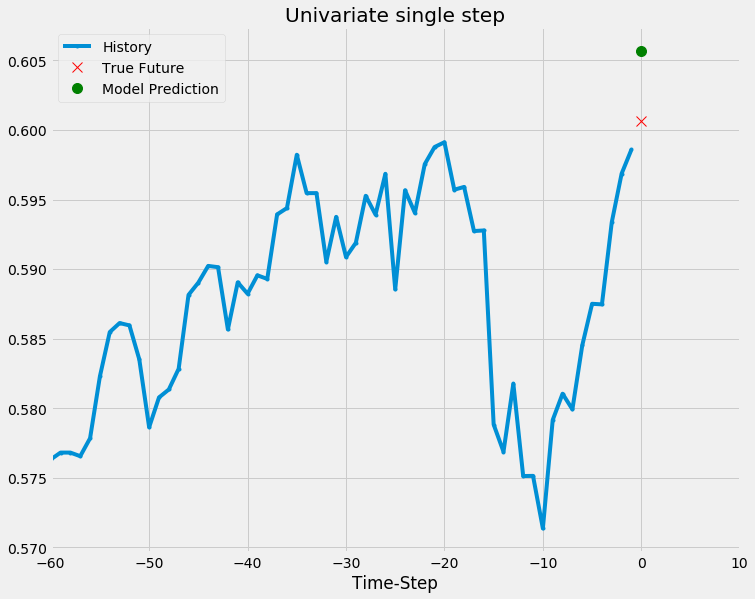

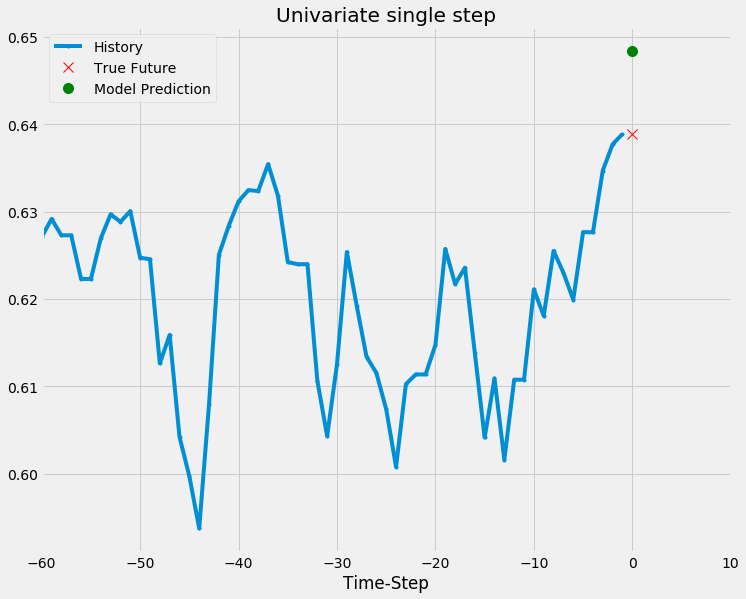

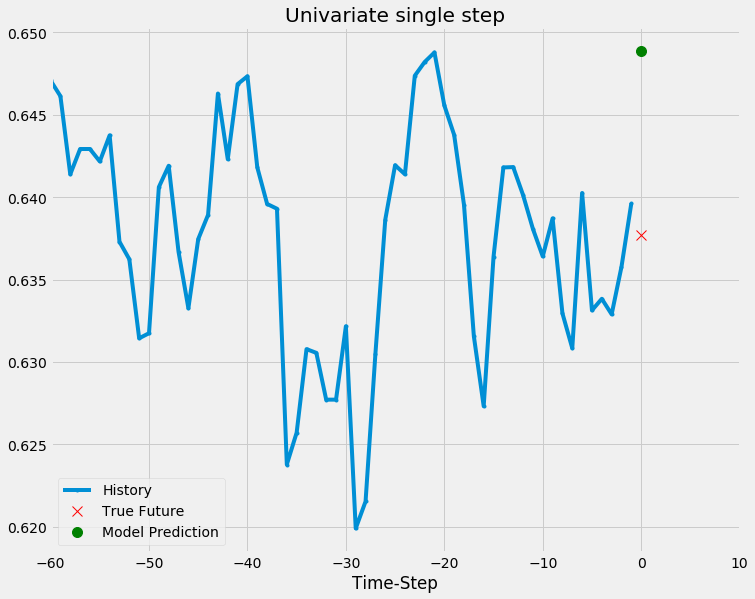

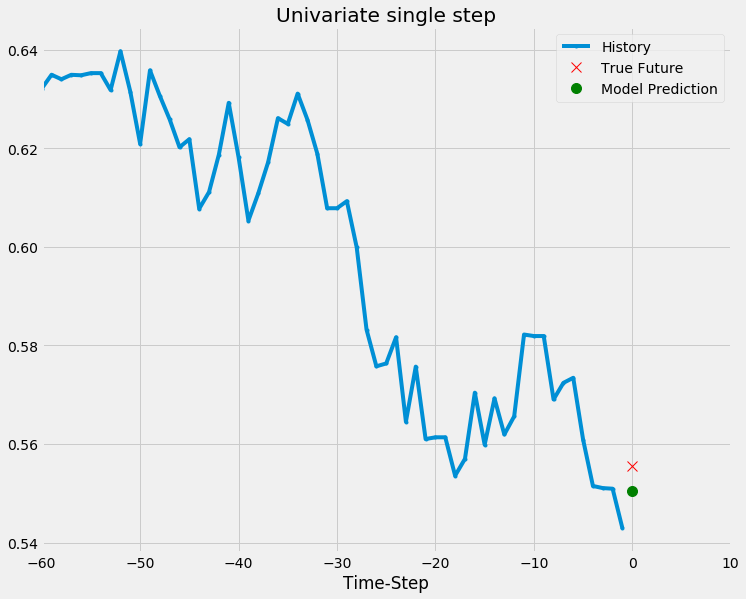

In [70]:
for x, y in val_univariate.take(5):
    plot = show_plot([x[0].numpy(), y[0].numpy(), UV.predict(x)[0]], 0, 'Univariate single step')
    plot.show()

### Multivariate

##### Feature extraction

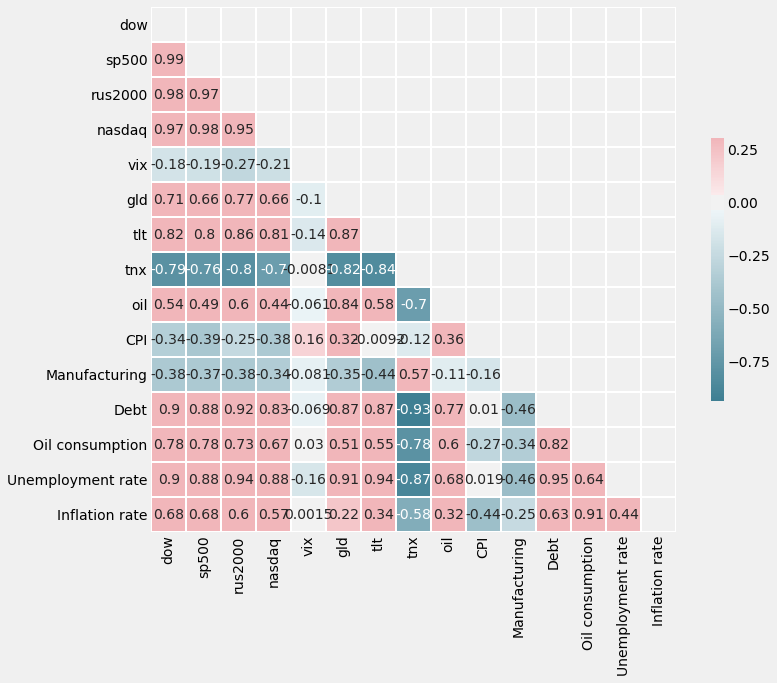

In [71]:
correlation(sum)

In [72]:
pd.concat([sum['rus2000'], sum['nasdaq']], axis = 1).corr()

,rus2000,nasdaq
rus2000,1.000000,0.954077
nasdaq,0.954077,1.000000


In [73]:
pd.concat([sum['dow'], sum['nasdaq']], axis = 1).corr()

,dow,nasdaq
dow,1.000000,0.972354
nasdaq,0.972354,1.000000


In [0]:
dataset = sum.drop(['rus2000', 'dow', 'sp500'], axis=1)
targ = sum['sp500']

In [75]:
dataset

,nasdaq,vix,gld,tlt,tnx,oil,CPI,Manufacturing,Debt,Oil consumption,Unemployment rate,Inflation rate
Date,,,,,,,,,,,,
1990-01-01,459.299988,17.240000,401.65,81.519997,7.940,21.25,5.4,5.20,127.400,62.5981,3051958.0,16988.255518
1990-01-02,459.299988,17.240000,401.65,81.519997,7.940,21.25,5.4,5.20,127.400,62.5981,3143754.0,16988.255518
1990-01-03,460.899994,18.190001,396.30,81.519997,7.990,21.25,5.4,5.20,127.400,62.5981,3143754.0,16988.255518
1990-01-04,459.399994,19.219999,394.95,81.519997,7.980,21.25,5.4,5.20,127.400,62.5981,3143754.0,16988.255518
1990-01-05,458.200012,20.110001,401.20,81.519997,7.990,21.25,5.4,5.20,127.400,62.5981,3143754.0,16988.255518
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-11,8464.280273,12.690000,1465.50,135.000000,1.943,59.37,3.6,1.76,257.346,104.0489,22023283.0,20455.668043
2019-11-12,8486.089844,12.680000,1455.00,135.619995,1.909,59.37,3.6,1.76,257.346,104.0489,22023283.0,20455.668043
2019-11-13,8482.099609,13.000000,1463.45,136.500000,1.870,59.37,3.6,1.76,257.346,104.0489,22023283.0,20455.668043


In [76]:
coeff, score = lr_fit(dataset, targ)
coeff, score

(array([424.33859781, -13.70693611, -31.12579474, -49.15407304,
        -47.3541074 ,  21.7858337 , -82.76295914, -11.68675845,
          1.20999247,  93.77936949, 161.67811247,  -4.44707392]),
 0.992594624476549)

In [77]:
dataset = dataset.drop(['tlt', 'Inflation rate'], axis = 1)
coeff, score = lr_fit(dataset, targ)
coeff, score

(array([431.18022205, -13.70305013, -58.11715353, -22.562711  ,
         34.20435562, -67.01148078, -14.10274436,  -7.75046835,
        105.78623689, 144.618966  ]), 0.9924411279422596)

In [78]:
dataset

,nasdaq,vix,gld,tnx,oil,CPI,Manufacturing,Debt,Oil consumption,Unemployment rate
Date,,,,,,,,,,
1990-01-01,459.299988,17.240000,401.65,7.940,21.25,5.4,5.20,127.400,62.5981,3051958.0
1990-01-02,459.299988,17.240000,401.65,7.940,21.25,5.4,5.20,127.400,62.5981,3143754.0
1990-01-03,460.899994,18.190001,396.30,7.990,21.25,5.4,5.20,127.400,62.5981,3143754.0
1990-01-04,459.399994,19.219999,394.95,7.980,21.25,5.4,5.20,127.400,62.5981,3143754.0
1990-01-05,458.200012,20.110001,401.20,7.990,21.25,5.4,5.20,127.400,62.5981,3143754.0
...,...,...,...,...,...,...,...,...,...,...
2019-11-11,8464.280273,12.690000,1465.50,1.943,59.37,3.6,1.76,257.346,104.0489,22023283.0
2019-11-12,8486.089844,12.680000,1455.00,1.909,59.37,3.6,1.76,257.346,104.0489,22023283.0
2019-11-13,8482.099609,13.000000,1463.45,1.870,59.37,3.6,1.76,257.346,104.0489,22023283.0


In [79]:
dataset = dataset.drop(['vix', 'Manufacturing', 'Debt'], axis = 1)
coeff, score = lr_fit(dataset, targ)
coeff, score

(array([429.88496765, -69.029326  , -26.02578111,  27.98812539,
        -63.37669427, 102.06983742, 160.48419148]), 0.9918265912427356)

In [80]:
dataset

,nasdaq,gld,tnx,oil,CPI,Oil consumption,Unemployment rate
Date,,,,,,,
1990-01-01,459.299988,401.65,7.940,21.25,5.4,62.5981,3051958.0
1990-01-02,459.299988,401.65,7.940,21.25,5.4,62.5981,3143754.0
1990-01-03,460.899994,396.30,7.990,21.25,5.4,62.5981,3143754.0
1990-01-04,459.399994,394.95,7.980,21.25,5.4,62.5981,3143754.0
1990-01-05,458.200012,401.20,7.990,21.25,5.4,62.5981,3143754.0
...,...,...,...,...,...,...,...
2019-11-11,8464.280273,1465.50,1.943,59.37,3.6,104.0489,22023283.0
2019-11-12,8486.089844,1455.00,1.909,59.37,3.6,104.0489,22023283.0
2019-11-13,8482.099609,1463.45,1.870,59.37,3.6,104.0489,22023283.0


In [81]:
dataset = dataset.drop(['tnx', 'oil'], axis = 1)
coeff, score = lr_fit(dataset, targ)
coeff, score

(array([421.59472308, -39.13346643, -55.59646612, 128.50651203,
        165.22315721]), 0.9917051652288233)

In [82]:
dataset

,nasdaq,gld,CPI,Oil consumption,Unemployment rate
Date,,,,,
1990-01-01,459.299988,401.65,5.4,62.5981,3051958.0
1990-01-02,459.299988,401.65,5.4,62.5981,3143754.0
1990-01-03,460.899994,396.30,5.4,62.5981,3143754.0
1990-01-04,459.399994,394.95,5.4,62.5981,3143754.0
1990-01-05,458.200012,401.20,5.4,62.5981,3143754.0
...,...,...,...,...,...
2019-11-11,8464.280273,1465.50,3.6,104.0489,22023283.0
2019-11-12,8486.089844,1455.00,3.6,104.0489,22023283.0
2019-11-13,8482.099609,1463.45,3.6,104.0489,22023283.0


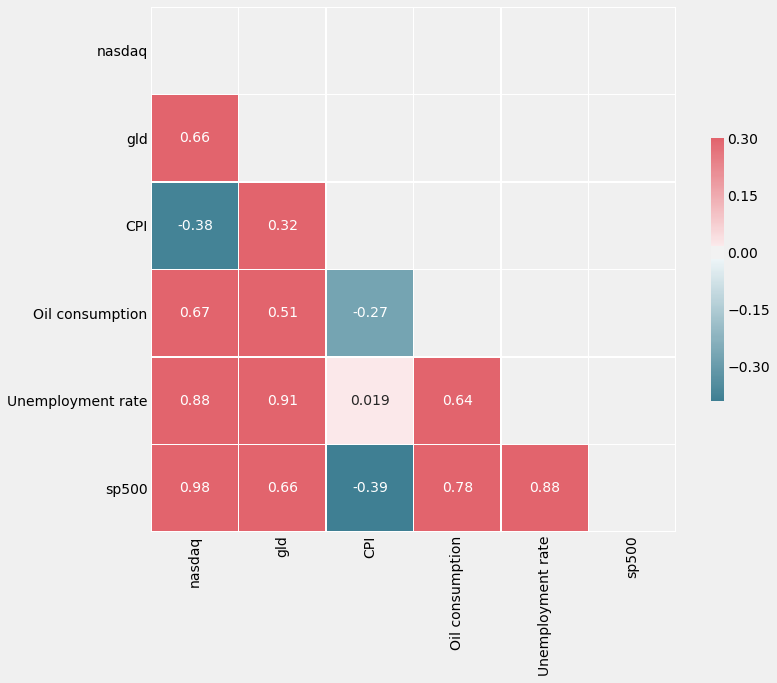

In [83]:
correlation(pd.concat([dataset, targ], axis = 1))

In [84]:
test = dataset.drop(['nasdaq'], axis = 1)
coeff, score = lr_fit(test, targ)
coeff, score

(array([-126.35253048, -195.99093562,  127.37983135,  618.23417746]),
 0.9621475277840054)

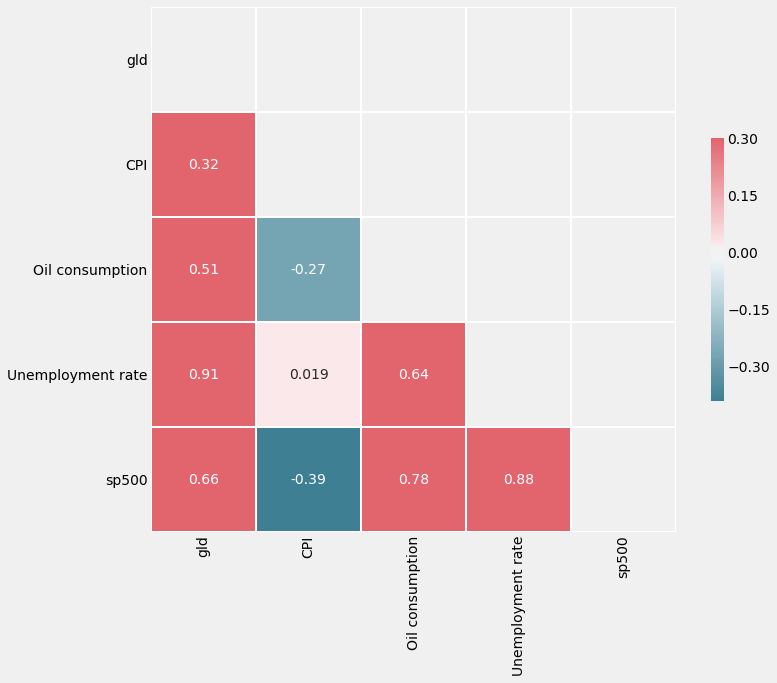

In [85]:
correlation(pd.concat([test, targ], axis = 1))

In [86]:
test = test.drop(['gld'], axis = 1)
coeff, score = lr_fit(test, targ)
coeff, score

(array([-235.94014321,  123.19901005,  506.95213363]), 0.9600248094749012)

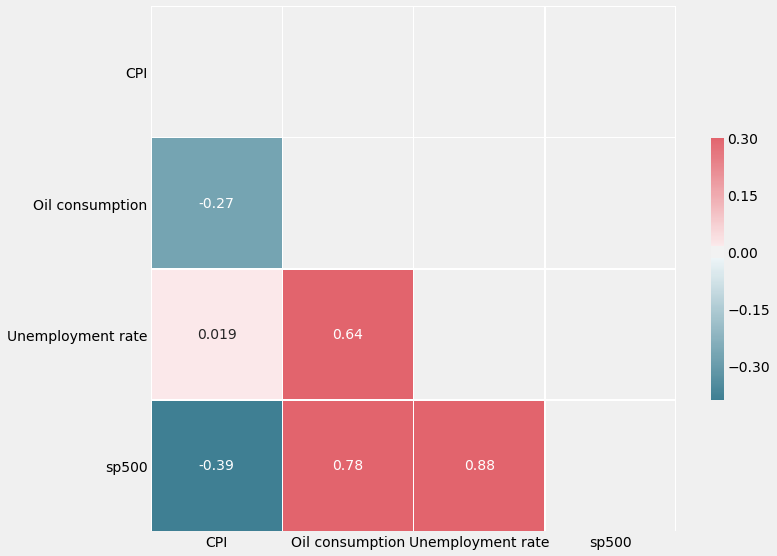

In [87]:
correlation(pd.concat([test, targ], axis = 1))

In [88]:
test = test.drop(['Oil consumption'], axis = 1)
coeff, score = lr_fit(test, targ)
coeff, score

(array([-271.09411683,  586.96203705]), 0.9422243645871126)

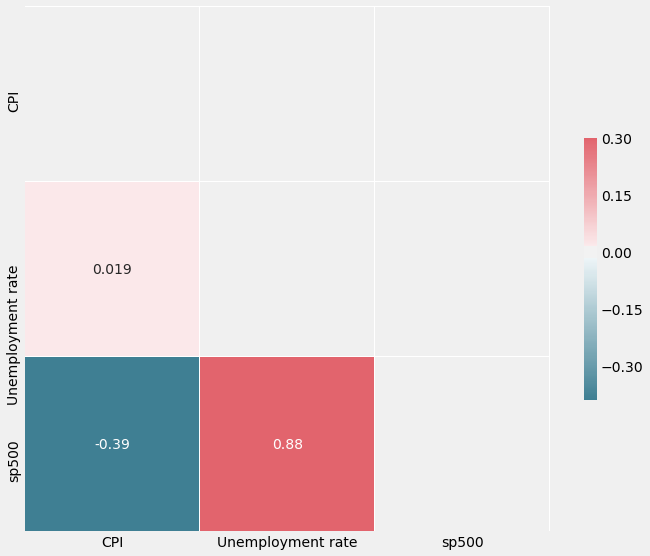

In [89]:
correlation(pd.concat([test, targ], axis = 1))

#### Single step

In [90]:
multi_data = np.array(pd.concat([test,targ], axis = 1)) #dataset
multi_data.shape

(7725, 3)

In [0]:
scm = MinMaxScaler(feature_range=(0, 1))
std = StandardScaler()
multi_data = scm.fit_transform(multi_data)

In [92]:
multi_data

array([[0.28787879, 0.        , 0.02273629],
       [0.28787879, 0.0048375 , 0.02273629],
       [0.28787879, 0.0048375 , 0.02240709],
       ...,
       [0.01515152, 0.99975775, 0.99064782],
       [0.01515152, 0.99975775, 0.99156457],
       [0.01515152, 0.99975775, 1.        ]])

In [0]:
past_history = 100
future_target = 10
STEP = 1

x_train_single, y_train_single = multivariate_data(multi_data, multi_data[:, 2], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(multi_data, multi_data[:, 2],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [94]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (100, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
SS_MV = tf.keras.models.Sequential([
    tf.keras.layers.GRU(64, return_sequences=False, kernel_regularizer = regularizers.l2(0.00005), input_shape=x_train_single.shape[-2:]),
    tf.keras.layers.BatchNormalization(),   
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1)
])
sgd = tf.keras.optimizers.SGD(lr=1e-3, momentum = .8, decay = 1e-6)
SS_MV.compile(optimizer = sgd,loss='mse')

In [97]:
for x, y in val_data_single.take(1):
    print(SS_MV.predict(x).shape)

(128, 1)


In [98]:
SS_MV.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                13056     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,377
Trainable params: 13,249
Non-trainable params: 128
_________________________________________________________________


In [99]:
# Load any existing weights
if os.path.exists(os.path.join(path, 'SS_MV.h5')):
    SS_MV.load_weights(os.path.join(path, 'SS_MV.h5'))

    epochs = 0
else:
    epochs = 50


single_step = SS_MV.fit(train_data_single, epochs = epochs, validation_data = val_data_single, steps_per_epoch = x_train_single.shape[0]//BATCH_SIZE, validation_steps = x_val_single.shape[0]//BATCH_SIZE)

Train for 47 steps, validate for 11 steps


In [0]:
if epochs!=0:
    SS_MV.save_weights(os.path.join(path, 'SS_MV.h5'))

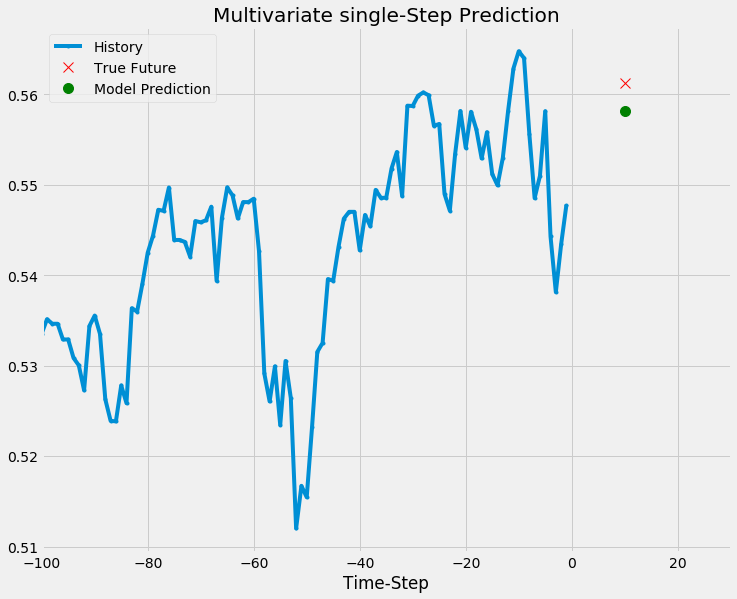

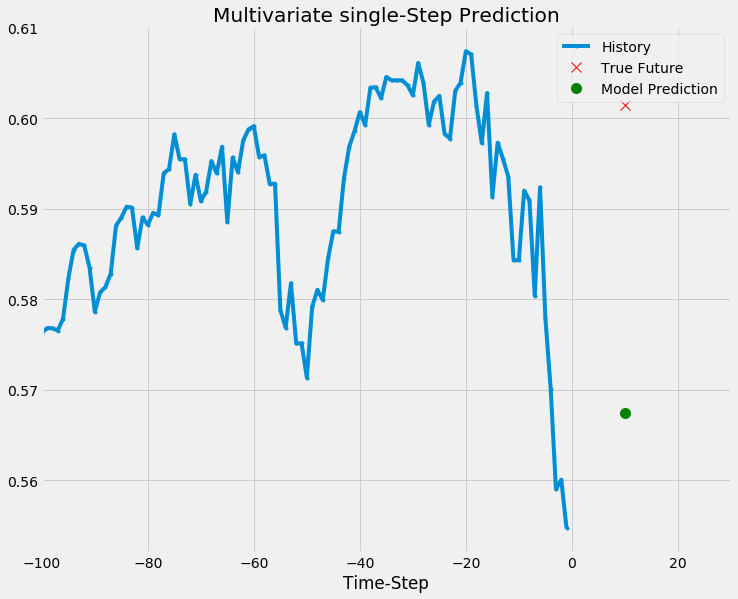

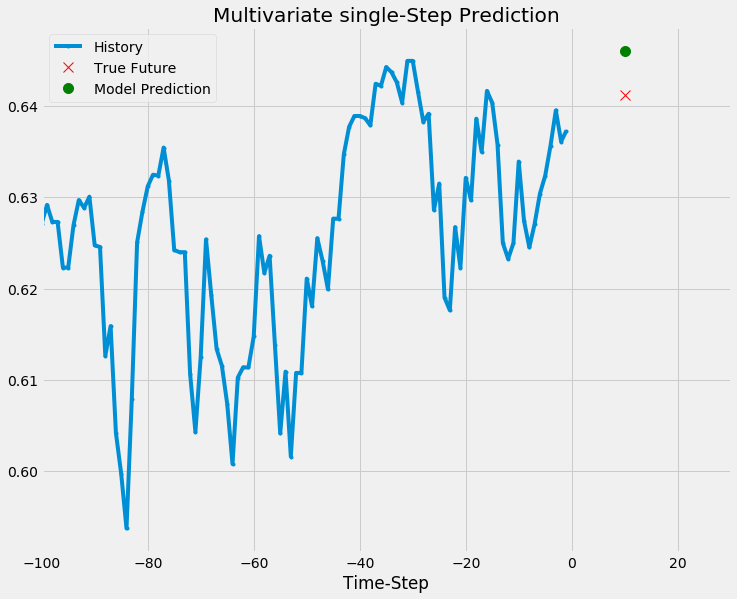

In [101]:
# Single step prediction

for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:,2].numpy(), y[0].numpy(), SS_MV.predict(x)[0]], 10, 'Multivariate single-Step Prediction')
    plot.show()

#### Multi-Step model

In [0]:
future_target = 10
STEP = 1
x_train_multi, y_train_multi = multivariate_data(multi_data, multi_data[:, 2], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(multi_data, multi_data[:, 2],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP)

In [103]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target price to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (100, 3)

 Target price to predict : (10,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

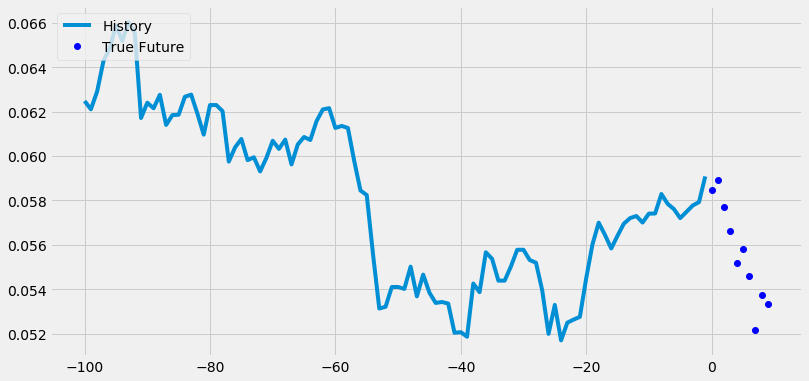

In [105]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
weight_decay = 0.00005

MS_MV = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer = regularizers.l2(weight_decay), activation = 'tanh', input_shape=x_train_multi.shape[-2:]),
    #tf.keras.layers.BatchNormalization(),   
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.LSTM(16, return_sequences=False, kernel_regularizer = regularizers.l2(weight_decay), activation = 'relu'),
    #tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(.1), 
    tf.keras.layers.Dense(future_target)
])
sgd = tf.keras.optimizers.SGD(lr=1e-3, momentum = .9, decay = 1e-5)
MS_MV.compile(optimizer = tf.keras.optimizers.RMSprop(clipvalue=1.0),loss = 'mae')

In [107]:
for x, y in val_data_multi.take(1):
    print (MS_MV.predict(x).shape)

(128, 10)


In [108]:
MS_MV.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 32)           4608      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 7,914
Trainable params: 7,914
Non-trainable params: 0
_________________________________________________________________


In [109]:
# Load any existing weights
if os.path.exists(os.path.join(path, 'MS_MV.h5')):
    MS_MV.load_weights(os.path.join(path, 'MS_MV.h5'))
    epochs = 0
else:
    epochs = 100

multi_step = MS_MV.fit(train_data_multi, epochs = epochs, validation_data = val_data_multi, steps_per_epoch = x_train_multi.shape[0]//BATCH_SIZE, validation_steps = x_val_multi.shape[0]//BATCH_SIZE)

Train for 47 steps, validate for 11 steps


In [0]:
if epochs!=0:
    MS_MV.save_weights(os.path.join(path, 'MS_MV.h5'))

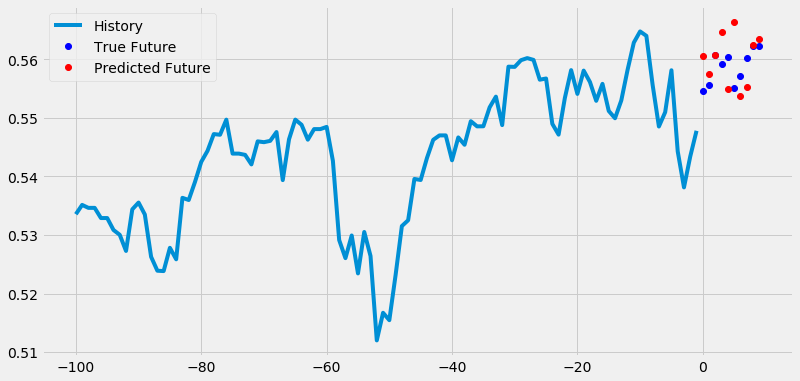

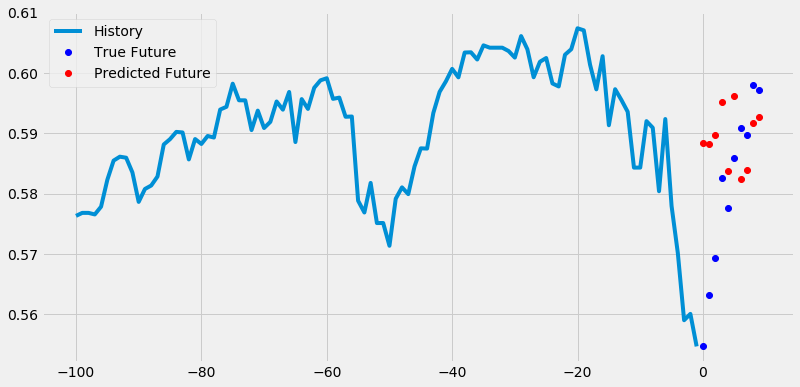

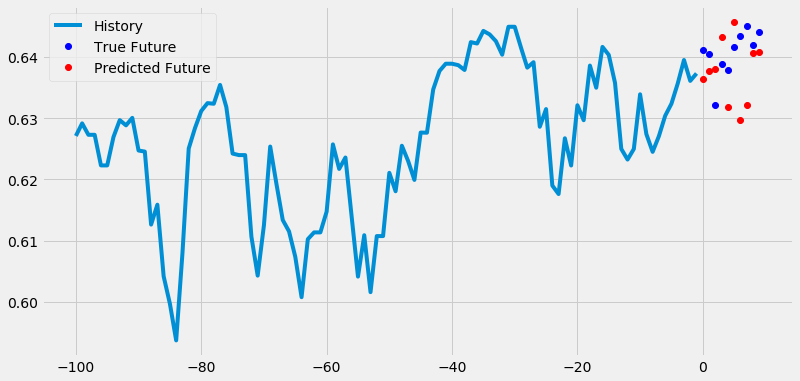

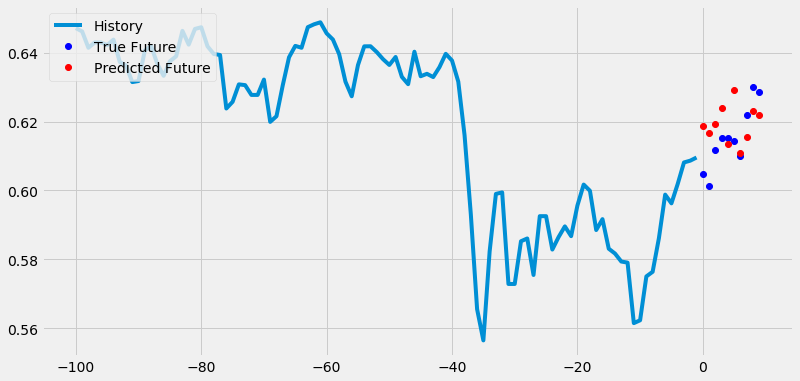

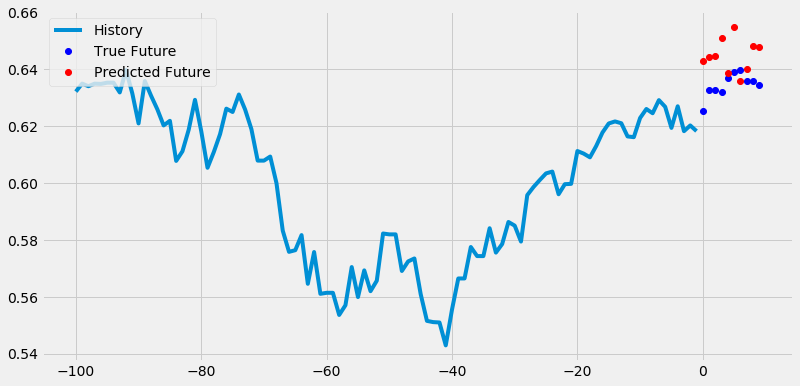

In [111]:
for x, y in val_data_multi.take(5):
    multi_step_plot(x[0], y[0], MS_MV.predict(x)[0])